In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [8]:
def main():
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()

In [9]:
from planning_utils import a_star

In [10]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-1.22397452e+02  3.77924795e+01  7.90000000e-02], local position [-0.05147329 -0.14693961 -0.07947729]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.7924795 -122.3974516 0.079
gh:  [-122.39745   37.79248    0.     ]
gp:  [-1.22397452e+02  3.77924795e+01  7.90000000e-02]
lp: [-0.05638274 -0.14051509 -0.079     ]
gsf:  315.9436172586866 444.8594849099172
gs:  (316, 445)
change [-0.32450202  0.48523726 -0.20841757]
goal:  (-122.40069662023302, 37.79733187255444, -2.005175662639734)
lg:  [ 536.47666761 -289.30070625    2.00517566]
ggf:  852.4766676137224 155.6992937520845
156 920
gg:  (852, 156) 1.0
change [ 0.13535319 -0.02577939 -0.15767596]
goal:  (-122.3960980680882, 37.79222170609631, -1.497759648278976)
lg:  [-27.88964125 119.21647251   1.49775965]
ggf:  288.11035875137895 564.216472513740

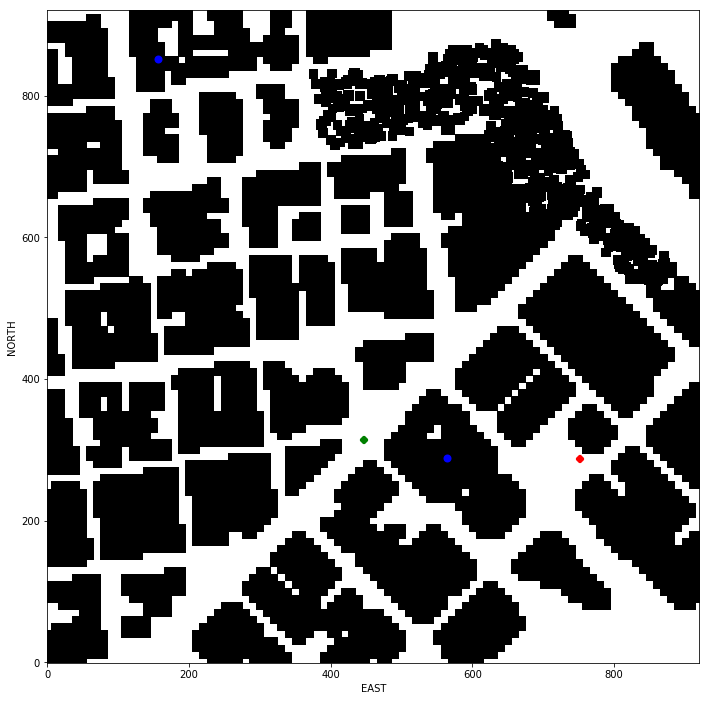

1000 7837 48.38477631085021 313.5733884343726 (329, 488)
2000 15682 16.970562748477146 322.3899465472138 (304, 445)
3000 23522 43.426406871192846 330.55355640602875 (347, 469)
4000 31304 63.22539674441614 338.0962755220705 (361, 485)
5000 39079 50.49747468305831 345.5228973164307 (352, 462)
6000 46917 53.32590180780449 352.6918985409004 (354, 458)
7000 54682 42.01219330881975 358.01852235936263 (286, 434)
8000 62568 93.33809511662417 361.36234775059756 (382, 499)
9000 70470 128.72287142747433 363.52065676626324 (395, 541)
10000 78237 249.5046173579953 365.5950993106515 (322, 639)
11000 85951 87.26702730475871 368.0801324120524 (378, 484)
12000 93730 314.78888860545743 370.57419132938287 (302, 696)
13000 101633 138.45079348883226 372.25626818949024 (404, 547)
14000 109585 163.0365799264593 373.87538090958003 (401, 572)
Found a path.
305


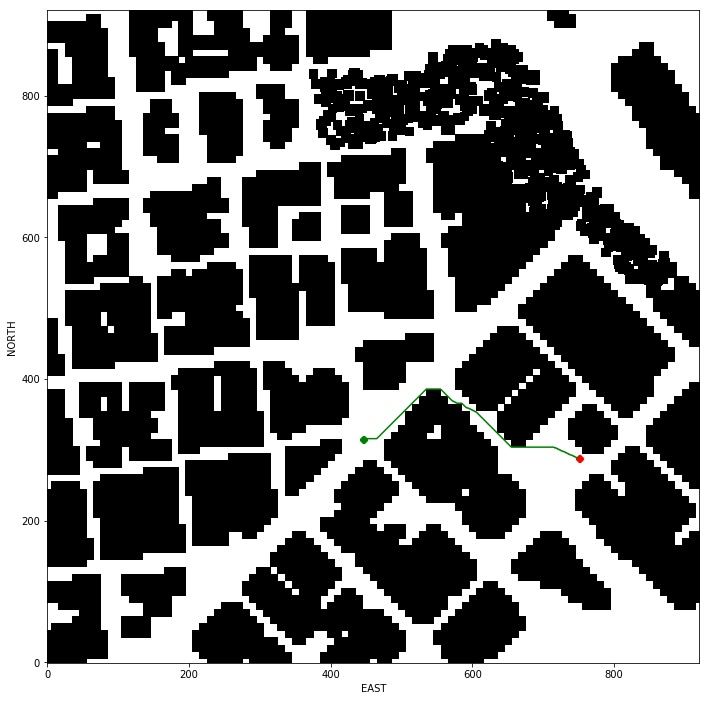

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [0, 1, 5, 0]
waypoint transition
target position [0, 2, 5, 0]
waypoint transition
target position [0, 3, 5, 0]
waypoint transition
target position [0, 4, 5, 0]
waypoint transition
target position [0, 5, 5, 0]
waypoint transition
target position [0, 6, 5, 0]
waypoint transition
target position [0, 7, 5, 0]
waypoint transition
target position [0, 8, 5, 0]
waypoint transition
target position [0, 9, 5, 0]
waypoint transition
target position [0, 10, 5, 0]
waypoint transition
target position [0, 11, 5, 0]
waypoint transition
target position [0, 12, 5, 0]
waypoint transition
target position [0, 13, 5, 0]
waypoint transition
target position [0, 14, 5, 0]
waypoint transition
target position [0, 15, 5, 0]
waypoint transition
target position [0, 16, 5, 0]
waypoint transition
target position [0, 17, 5, 0]
waypoint transition
target position [0, 18, 5, 0]
waypoi

waypoint transition
target position [38, 160, 5, 0]
waypoint transition
target position [37, 161, 5, 0]
waypoint transition
target position [36, 162, 5, 0]
waypoint transition
target position [35, 163, 5, 0]
waypoint transition
target position [34, 164, 5, 0]
waypoint transition
target position [33, 165, 5, 0]
waypoint transition
target position [32, 166, 5, 0]
waypoint transition
target position [31, 167, 5, 0]
waypoint transition
target position [30, 168, 5, 0]
waypoint transition
target position [29, 169, 5, 0]
waypoint transition
target position [28, 170, 5, 0]
waypoint transition
target position [27, 171, 5, 0]
waypoint transition
target position [26, 172, 5, 0]
waypoint transition
target position [25, 173, 5, 0]
waypoint transition
target position [24, 174, 5, 0]
waypoint transition
target position [23, 175, 5, 0]
waypoint transition
target position [22, 176, 5, 0]
waypoint transition
target position [21, 177, 5, 0]
waypoint transition
target position [20, 178, 5, 0]
waypoint tra

In [11]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    voxmap = create_voxmap(data, 1)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    self.set_home_position(lat0, lon0, 0)
    print((lon0, lat0), " vs ", (-north_offset, -east_offset))    
    print("lla: ",self._latitude, self._longitude, self._altitude)
    print("gh: ",self.global_home)
    print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))
    #3d
    #grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])))
    #2d
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("gs: ",grid_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    grid_shape = grid.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * 10.0)
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #3d
        #grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))
        #2d
        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        print(grid_goal[1], grid_shape[1] - 1)
        if grid_goal[0] >= grid_shape[0]:
            grid_goal = (grid_shape[0] - 1, grid_goal[1])
        elif grid_goal[0] < 0:
            grid_goal = (0, grid_goal[1])            
        if grid_goal[1] >= grid_shape[1]:
            grid_goal = (grid_goal[0], grid_shape[1] - 1)
        elif grid_goal[1] < 0:
            grid_goal = (grid_goal[0], 0)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        print("gg: ",grid_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    print("gg: ",grid_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Local Start and Goal: ', grid_start, grid_goal)
    plot(grid, grid_start, grid_goal, goal_list=goal_list)
    #3d
    #path, _ = a_star(voxmap, heuristic, grid_start, grid_goal)
    #2d
    path, _ = a_star(grid, heuristic, grid_start, grid_goal)
    print(len(path))
    #for p in path:
    #    print(p)
        #print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main()

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-1.22394027e+02  3.77922254e+01 -9.10000000e-02], local position [-2.83318920e+01  3.04554108e+02  9.12954211e-02]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.7922254 -122.394027 -0.091
gh:  [-122.3974533   37.7924804    0.       ]
gp:  [-1.22394027e+02  3.77922254e+01 -9.10000000e-02]
lp: [-2.63424653e+01  3.01853290e+02  9.10000000e-02]
gsf:  289.65753471665084 746.8532900190912
gs:  (290, 747)
change [-0.32084046 -0.29091048  0.14667142]
goal:  (-122.39723540462371, 37.78931629516854, 1.375714150798869)
lg:  [-350.9327283    21.44788635   -1.37571415]
ggf:  -34.93272829800844 466.4478863540571
466 920
gg:  (0, 466) 1.0
change [ 0.02147814 -0.21054347  0.03133796]
goal:  (-122.39381221856793, 37.79011996527956, 0.22237964830879917)
lg:  [-2.59817215e+02  3.22278399e+02 -2.22379648e

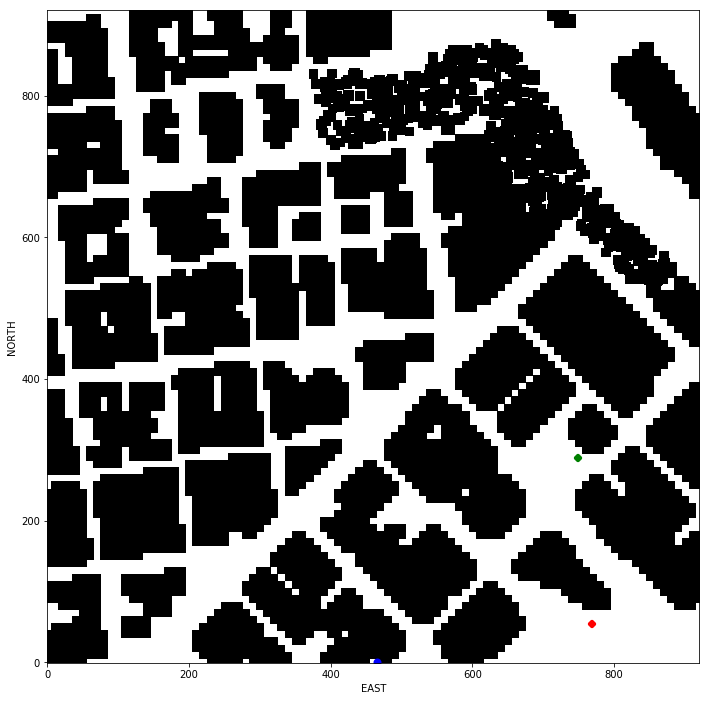

1000 7808 95.89949493661165 238.17387773267228 (197, 748)
2000 15713 65.72792206135783 240.15555748648188 (228, 738)
3000 23589 112.28427124746185 242.42265912744136 (186, 761)
4000 31462 118.21320343559638 245.13443885347277 (178, 732)
5000 39368 115.42640687119277 248.48654365152228 (189, 771)
6000 47181 137.3259018078045 251.8553739972807 (170, 778)
7000 55067 165.6396103067895 255.88372368821734 (144, 787)
8000 62928 13.656854249492383 260.17663033246714 (302, 751)
9000 70788 103.81118318204297 264.6620457846414 (204, 704)
10000 78604 118.46803743153534 269.1796826352156 (191, 700)
11000 86454 259.58073580374423 273.50912408092836 (61, 780)
Found a path.
244


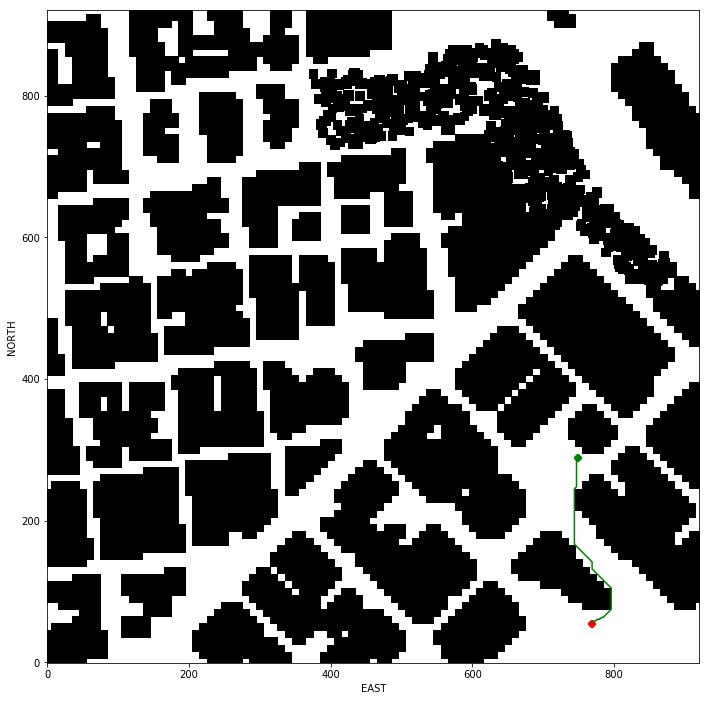

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [-26, 302, 5, 0]
waypoint transition
target position [-27, 302, 5, 0]
waypoint transition
target position [-28, 302, 5, 0]
waypoint transition
target position [-29, 302, 5, 0]
waypoint transition
target position [-30, 302, 5, 0]
waypoint transition
target position [-31, 302, 5, 0]
waypoint transition
target position [-32, 302, 5, 0]
waypoint transition
target position [-33, 302, 5, 0]
waypoint transition
target position [-34, 302, 5, 0]
waypoint transition
target position [-35, 302, 5, 0]
waypoint transition
target position [-36, 302, 5, 0]
waypoint transition
target position [-37, 302, 5, 0]
waypoint transition
target position [-38, 302, 5, 0]
waypoint transition
target position [-39, 302, 5, 0]
waypoint transition
target position [-40, 302, 5, 0]
waypoint transition
target position [-41, 302, 5, 0]
waypoint transition
target position [-42, 302, 5, 0]
waypoint transition
target position [-43, 302

KeyboardInterrupt: 

In [14]:
main()

In [12]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [13]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

ValueError: could not convert string to float: 'lat0 37.792480'

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())